# Zillow House Price Prediction Analysis
### By: Xavier Carter


##### Project Scope 
-  Predicting the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" of May-August, 2017.
    * To also include:
        - What state and county are located
        - The Tax rate distibution for each county
    

### Project Planning

    

- Create ReadMe.md with data dictionary, business goals, hypothesis and hypothesis testing results
- Aquire information from database 
- Prep and clean the data for more info for more visualizations, document findings
- Create deliverables for zillow that include the state and county for each property as well is the taxrate distributuons for each county
- Use visualizations to find possible MVP's, further my MVP testing with statstical analysis
- Create Hypothesis for each mvp,  alpha and find if rejecting the hypothesis is logical
- Create Baseline rmse score , document 
- Train classification models and evaluate results
- Choose best preforming model for test case , document findings
- Document conclusions / Take aways and next steps

## Aquire 

In [1]:
import pandas as pd
import numpy as np
import wrangle, prepare, Explore, evaluate

This funtion pulls data from the Zillow database for **single unit properties** between the **Hot Months**
 - Single unit properties defined as Single Family Residential, Rural Residence and Townhouses
 - Hot months range between May and August

In [2]:
zillow_df = wrangle.get_zillow_data()

In [3]:
zillow_df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,yearbuilt,regionidzip,fips,transactiondate
0,11721753,3.0,2.0,1316.0,205123.0,2627.48,1923.0,95997.0,6037.0,2017-07-21
1,11289917,3.0,2.0,1458.0,136104.0,2319.90,1970.0,97318.0,6037.0,2017-06-23
2,11705026,2.0,1.0,1421.0,35606.0,543.69,1911.0,96018.0,6037.0,2017-06-30
3,14269464,4.0,3.0,2541.0,880456.0,9819.72,2003.0,96958.0,6059.0,2017-06-01
4,11446756,3.0,2.0,1491.0,107110.0,1399.27,1955.0,96162.0,6037.0,2017-08-23


## Deliverables


- Here is a creation of a csv file containing property and the state, county, and tax rate of each property

In [4]:
deliverable_df = wrangle.zillow_engineering(zillow_df.copy())
deliverable_df = deliverable_df[['parcelid', 'State', 'County', 'taxrate' ]]
deliverable_df.to_csv('property_information.csv')

- Here is a creation of the tax rate distribution per county

<Figure size 648x360 with 0 Axes>

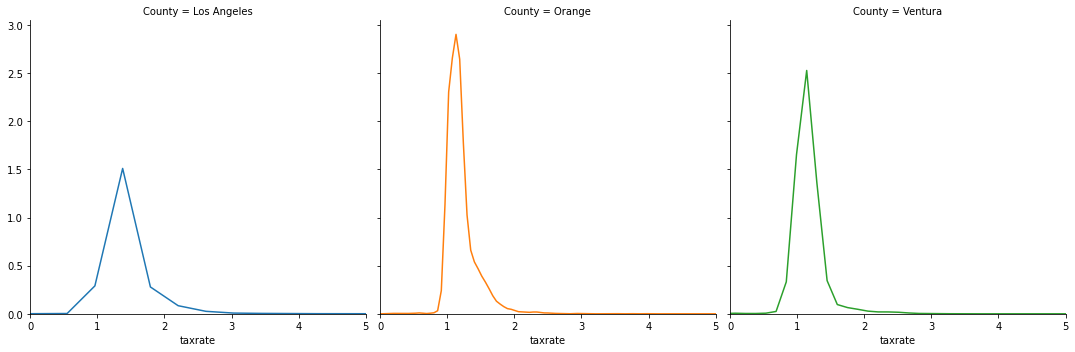

In [5]:
Explore.graph_distribution(deliverable_df, 'County', 'taxrate')

## Prepare
- Here I will continue the pipeline stage in order to prep for model building
     * Steps taken:
         - Gather summary statistics.
         - Check for nulls and remove or fill them.
         - Convert data types
         - Locate extreme outliers and remove them.

In [6]:
#looking back to original data prior to deliverable
zillow_df = zillow_df.drop(columns='taxamount')
zillow_df['taxrate'] = deliverable_df['taxrate']
zillow_df[:1]

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,regionidzip,fips,transactiondate,taxrate
0,11721753,3.0,2.0,1316.0,205123.0,1923.0,95997.0,6037.0,2017-07-21,1.28


In [7]:
wrangle.summerize_df(zillow_df)

-----shape------
28127 rows and 10 columns
---info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28127 entries, 0 to 28126
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28127 non-null  int64  
 1   bedroomcnt                    28127 non-null  float64
 2   bathroomcnt                   28127 non-null  float64
 3   calculatedfinishedsquarefeet  28080 non-null  float64
 4   taxvaluedollarcnt             28126 non-null  float64
 5   yearbuilt                     28056 non-null  float64
 6   regionidzip                   28110 non-null  float64
 7   fips                          28127 non-null  float64
 8   transactiondate               28127 non-null  object 
 9   taxrate                       28125 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.1+ MB
None
           parcelid    bedroomcnt   bathroomcnt  calculatedfin

### Takeaways
- Handle nulls. remove and filled accordingly
- convert zipcode and fips to strings, as they are actually catagorical features

In [8]:
zillow_df = wrangle.clean_zillow_data(zillow_df)

In [9]:
wrangle.summerize_df(zillow_df)

-----shape------
28065 rows and 10 columns
---info---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28065 entries, 0 to 28126
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28065 non-null  int64  
 1   bedroomcnt                    28065 non-null  float64
 2   bathroomcnt                   28065 non-null  float64
 3   calculatedfinishedsquarefeet  28065 non-null  float64
 4   taxvaluedollarcnt             28065 non-null  float64
 5   yearbuilt                     28065 non-null  float64
 6   regionidzip                   28065 non-null  object 
 7   fips                          28065 non-null  float64
 8   transactiondate               28065 non-null  object 
 9   taxrate                       28063 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB
None
           parcelid    bedroomcnt   bathroomcnt  calculatedfin

## Outlier Handling, Splitting and Scaling Data
- removing extreme outliers as an attempt to normalize data more
- Here Splitting and scaling will be handled

In [10]:
zillow_df.shape

(28065, 10)

In [11]:
#outliers removed on a normal 25 lower /75 upper quartile range
#bedroom and bathroom count weighted differenty, more outliers on the upper end

for i in zillow_df.drop(columns=['parcelid','yearbuilt', 'fips','transactiondate','regionidzip']):
    if i == 'bedroomcnt' or i =='bathroomcnt':
        zillow_df = wrangle.handle_outliers(zillow_df, i, .10, .65)
    else:
        zillow_df = wrangle.handle_outliers(zillow_df, i, .25, .65)

In [12]:
zillow_df.shape

(18460, 10)

In [13]:
train, validate, test = wrangle.split_for_model(zillow_df)

train(10337, 10),validate(4431, 10),test(3692, 10)


In [14]:
#min max scaling on continous variables, not including target                      
train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test, scale_type='MinMax',
                                                                to_scale=['calculatedfinishedsquarefeet','taxrate','yearbuilt'])

In [15]:
#continous variables specified scaled, everything else remains in its original unit of measure
train_scaled[:1]

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,regionidzip,fips,transactiondate,taxrate
2808,11004571,3.0,2.0,0.372578,517766.0,0.605839,96284.0,6037.0,2017-05-12,0.45098


## Exploration
- Visual exploration allows us to see possible trends visually before making MVP choices
    * Here We'll visualize possible correlations

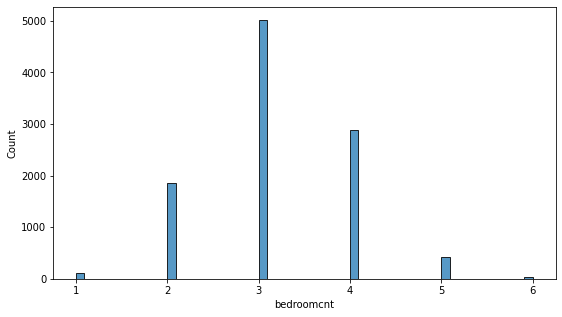

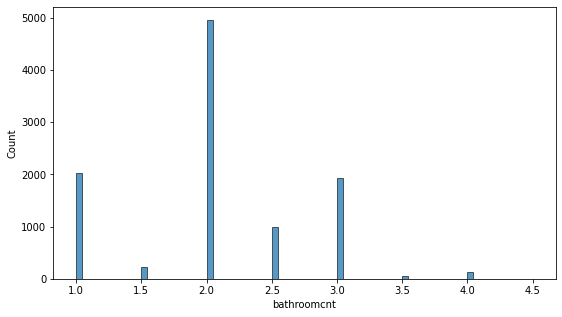

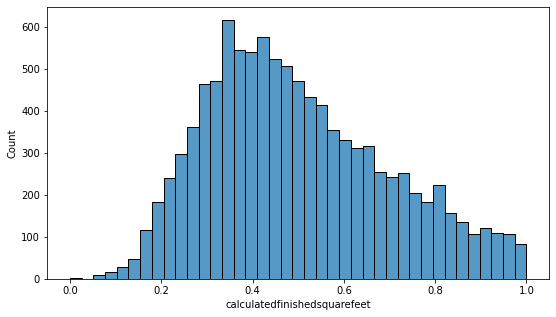

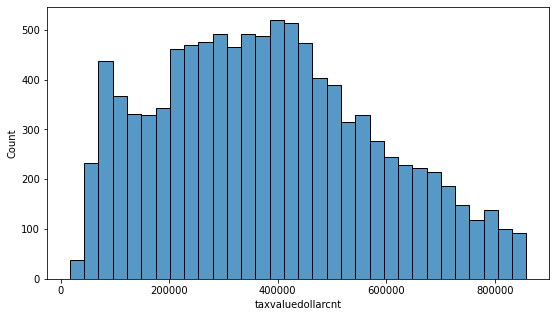

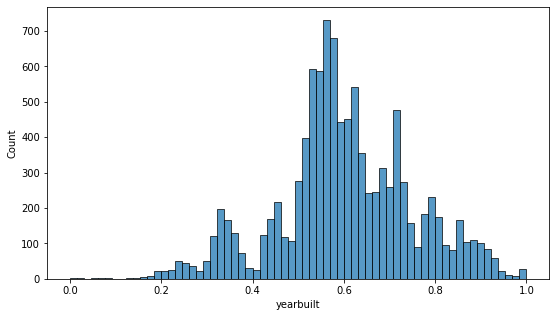

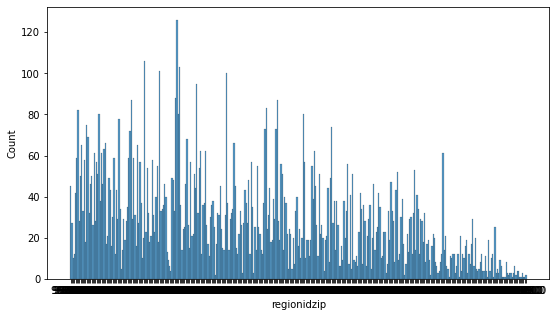

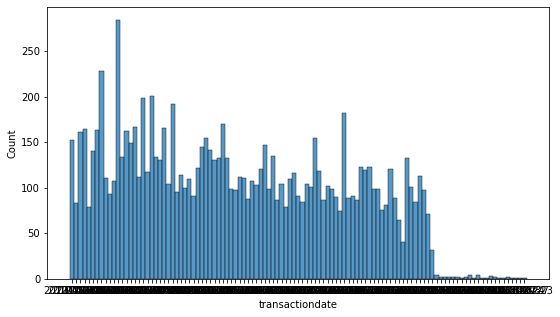

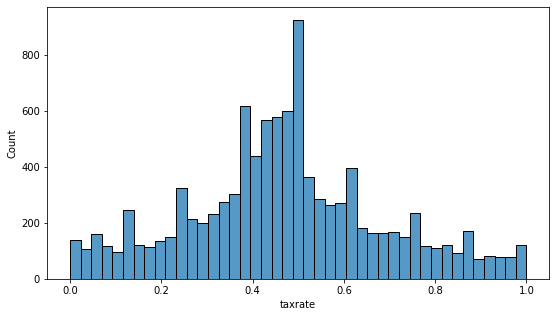

In [16]:
#distributions
Explore.get_distribution(train_scaled.drop(columns=['parcelid','fips']))

### Takeaways
- normally distributed data for the most part

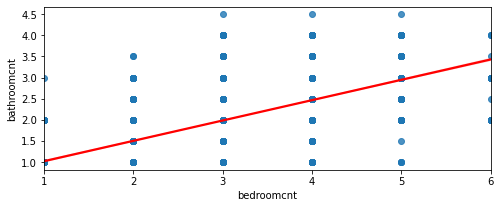

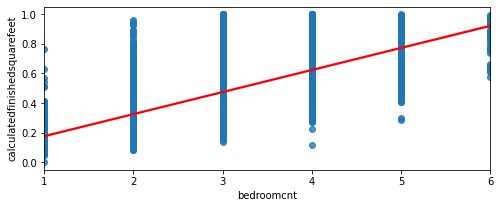

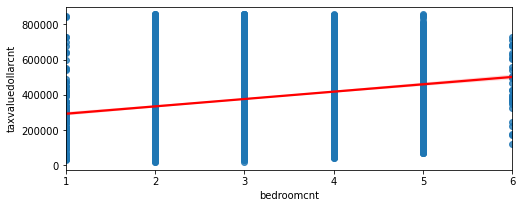

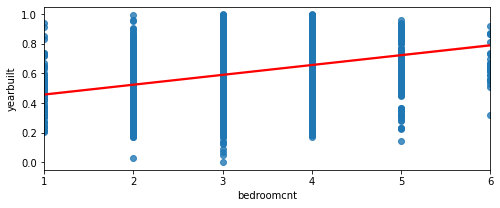

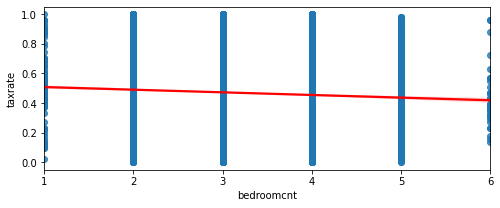

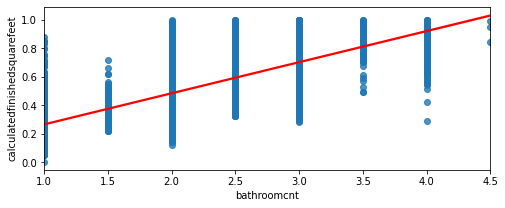

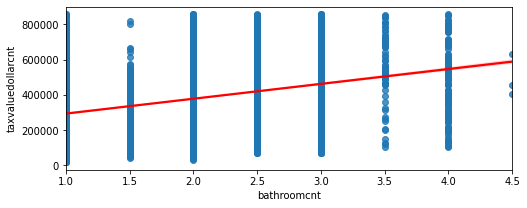

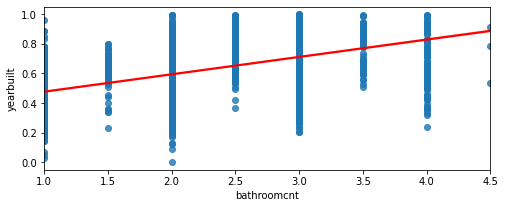

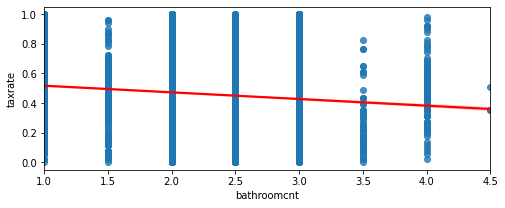

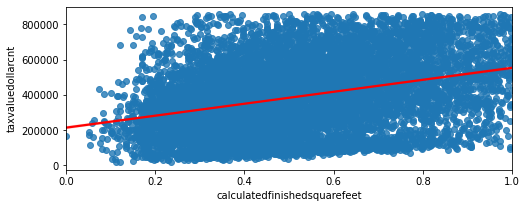

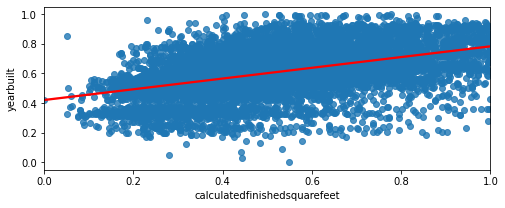

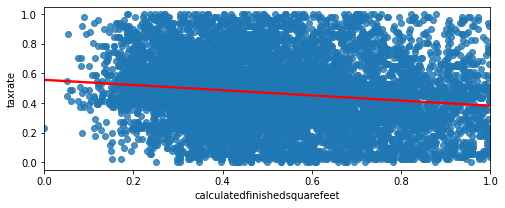

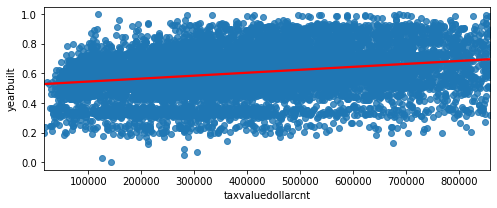

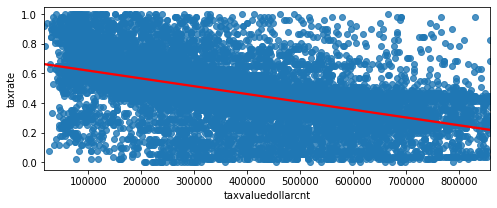

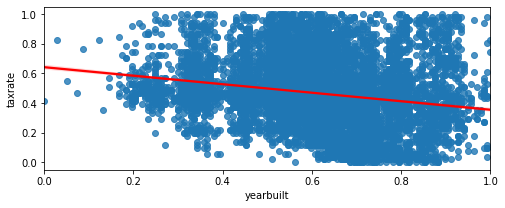

In [17]:
Explore.plot_variable_pairs(train_scaled.drop(columns=['parcelid','fips','transactiondate','regionidzip']), 2)

### Takeways
- the more expensive the unit, the smaller the tax rate

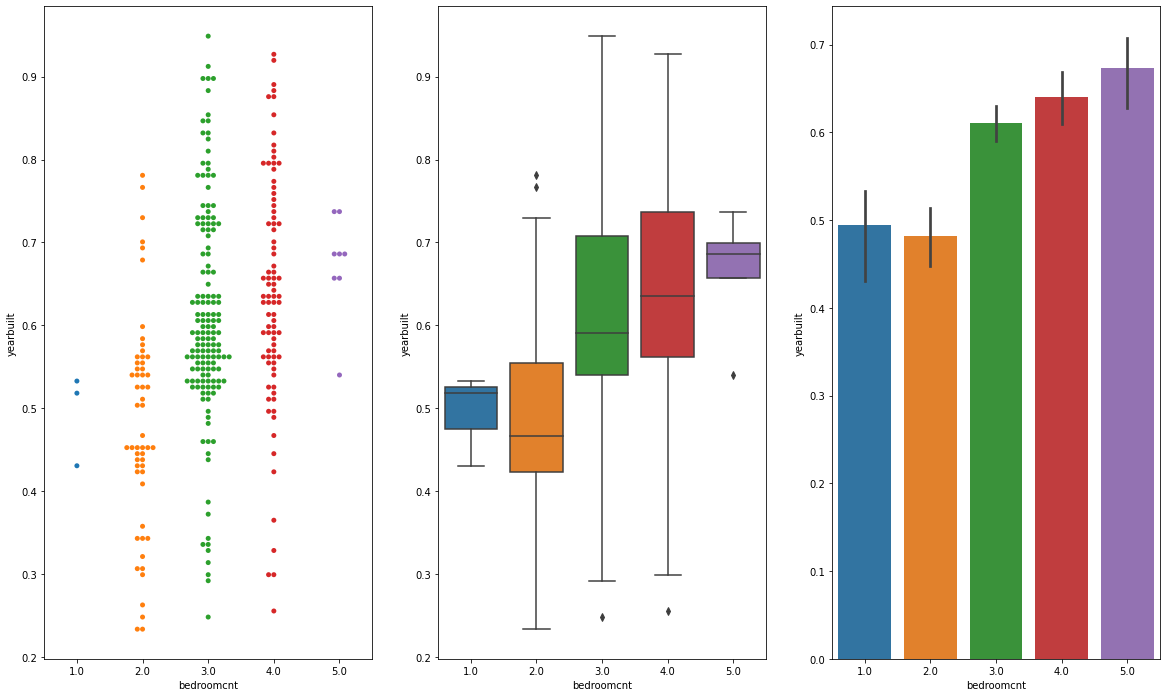

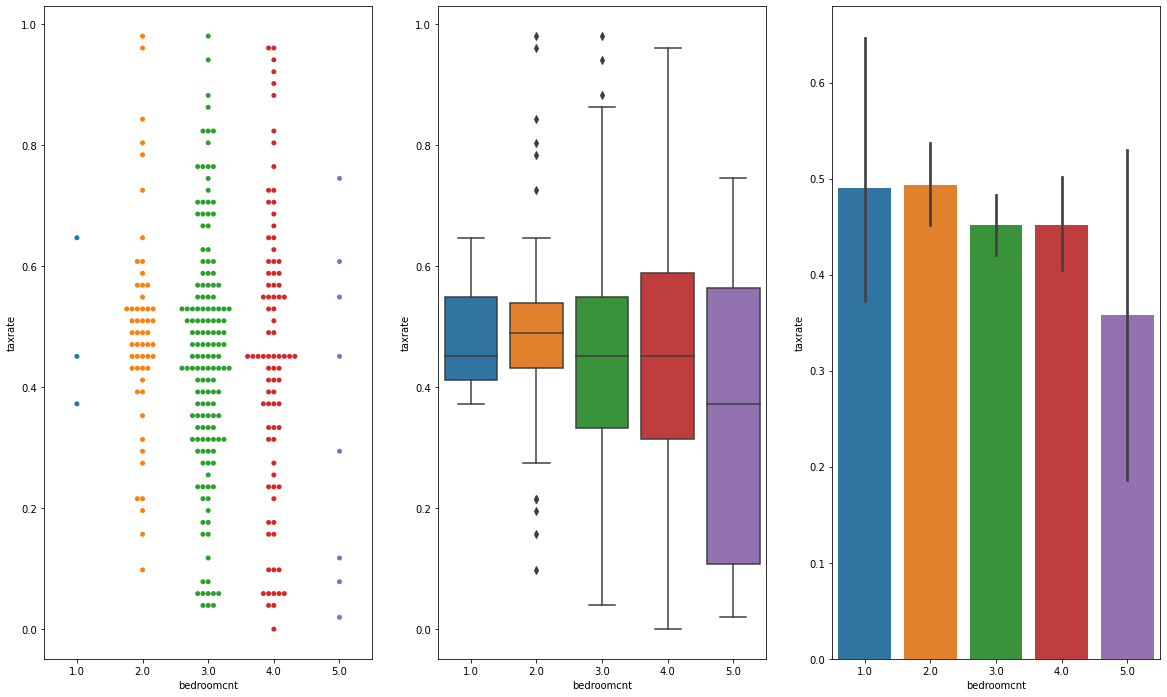

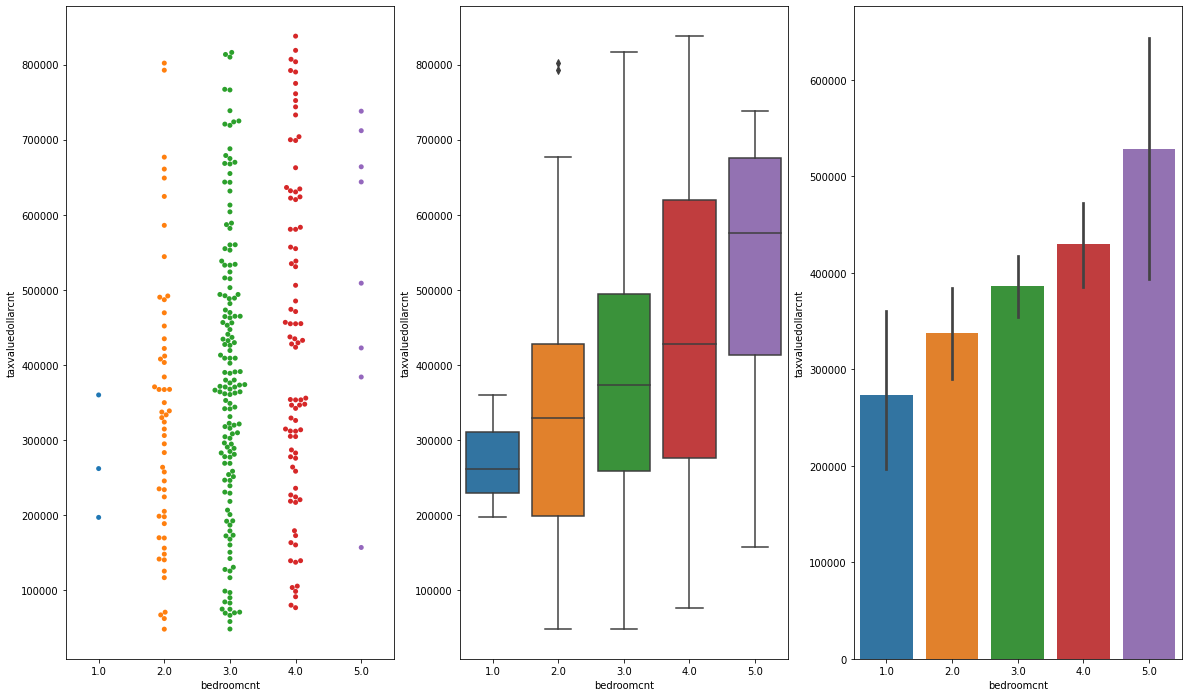

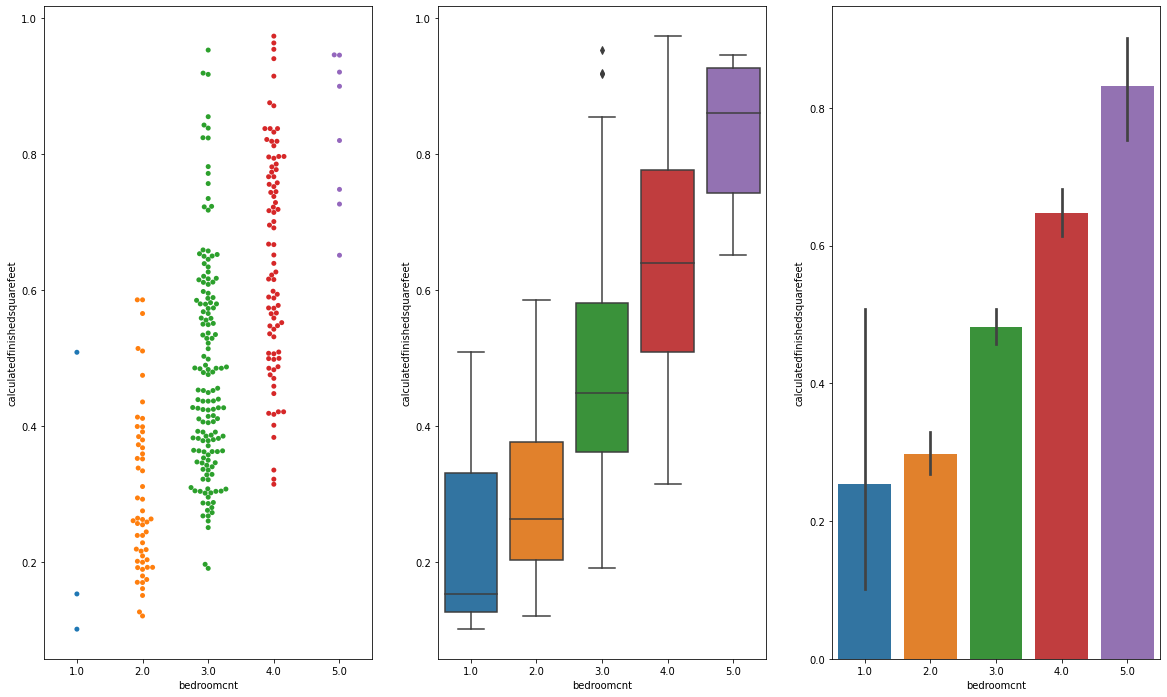

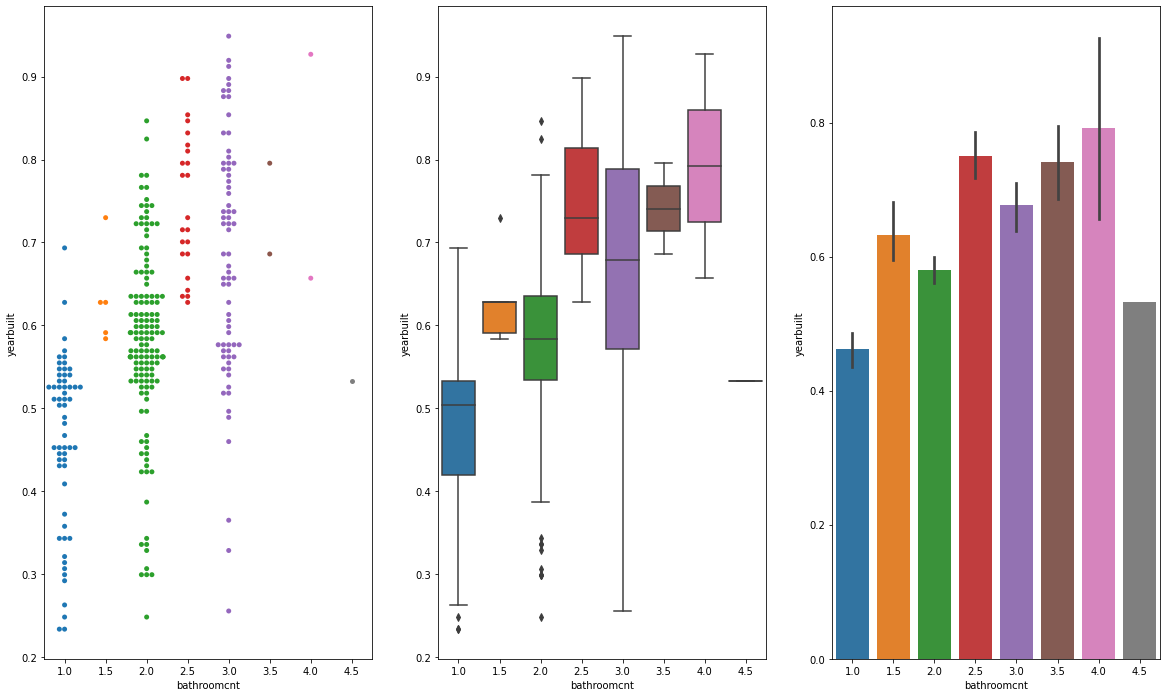

/opt/homebrew/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


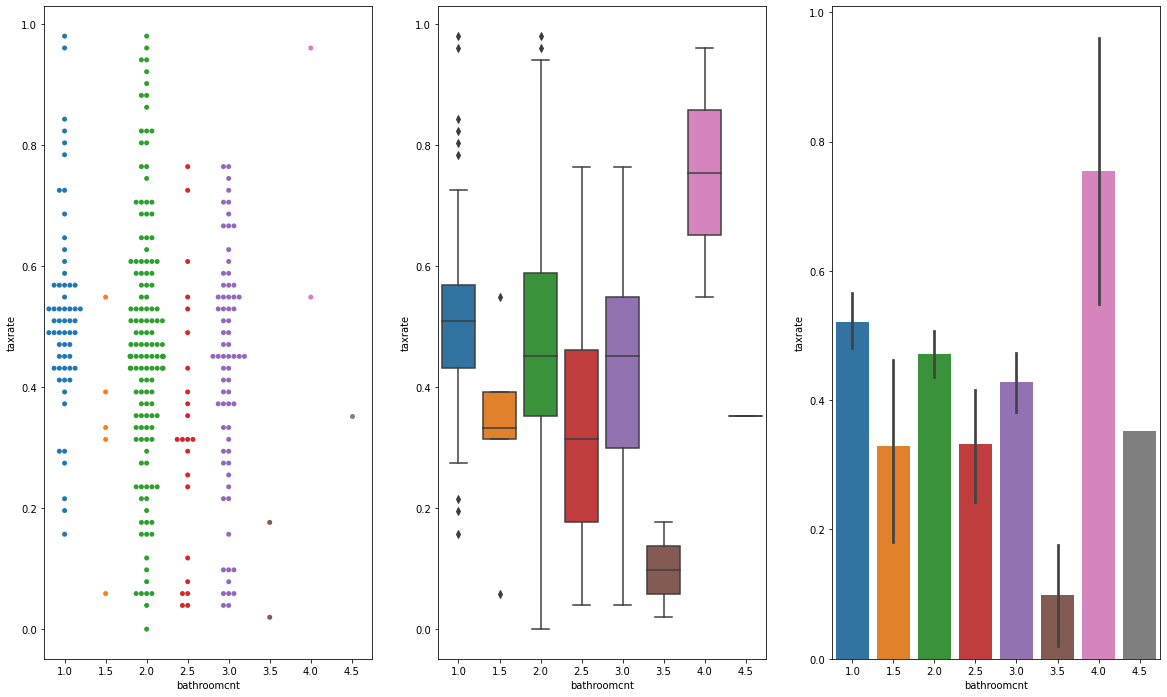

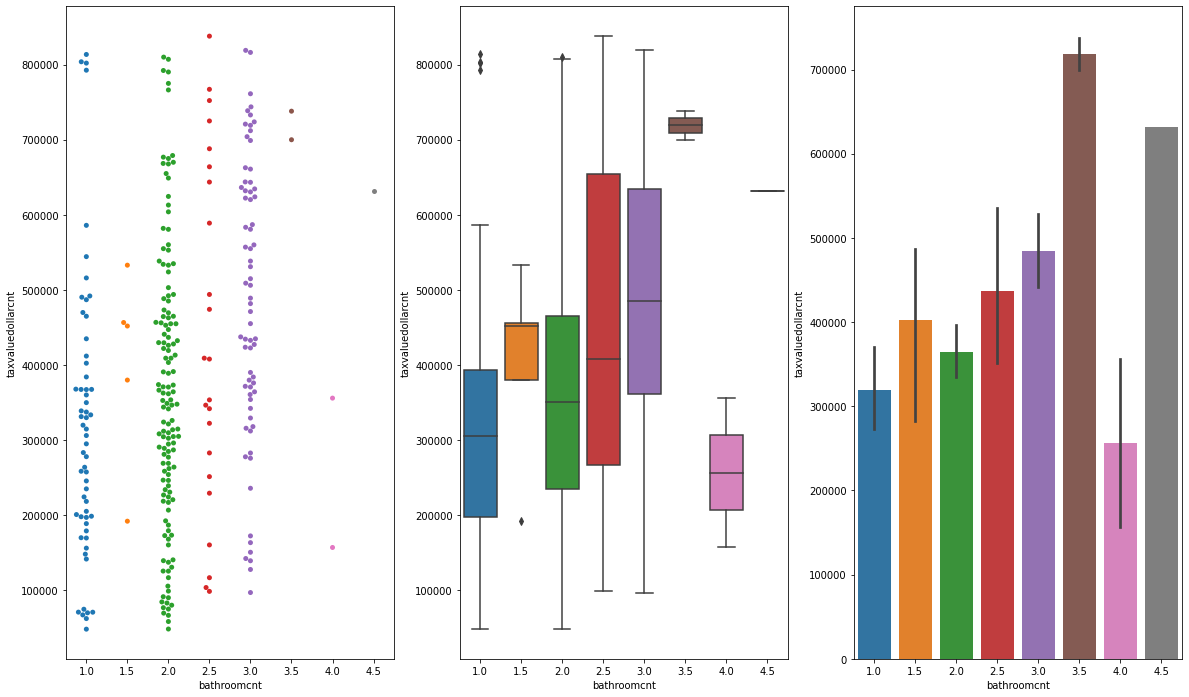

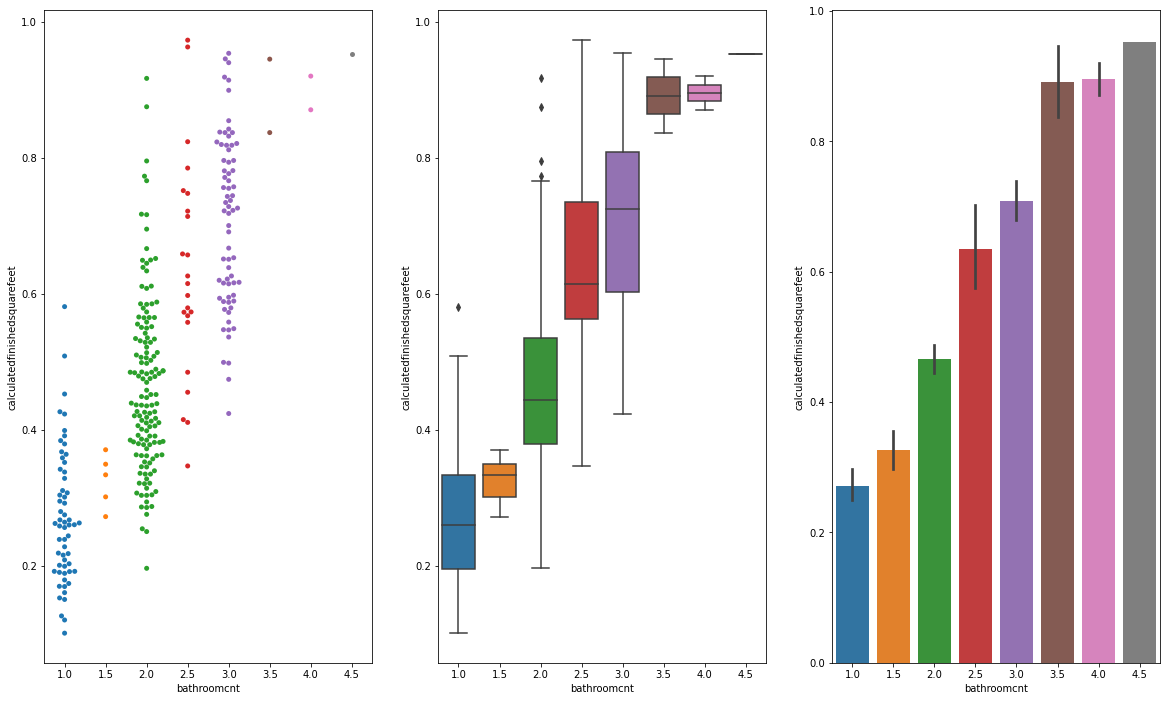

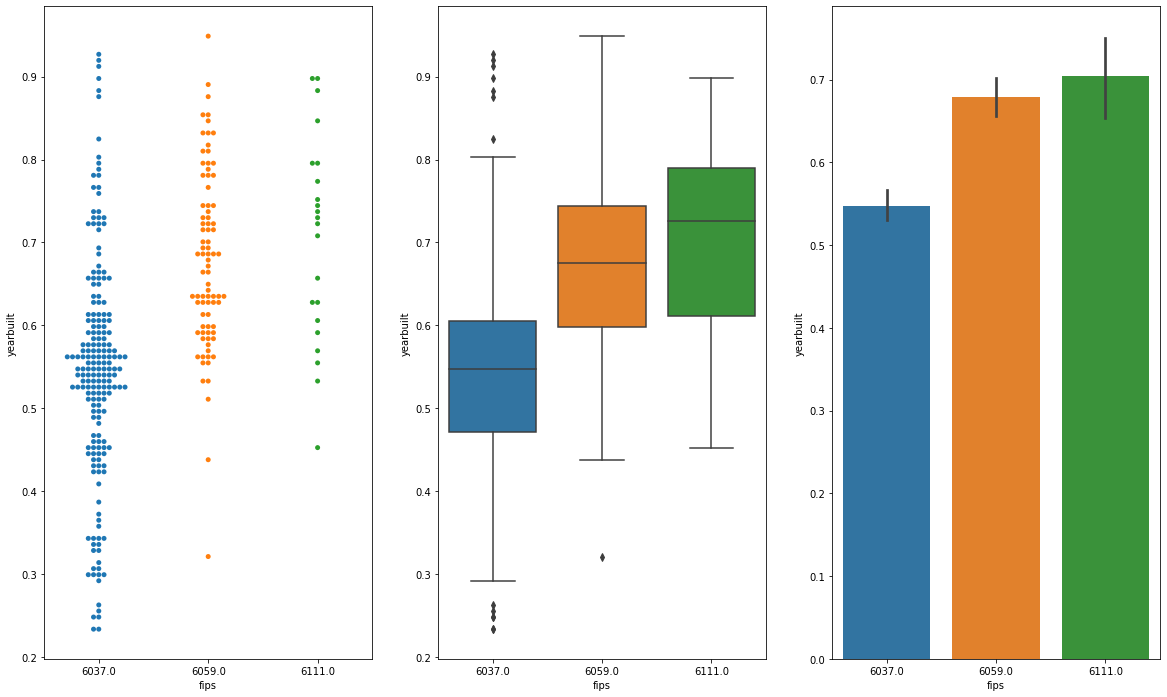

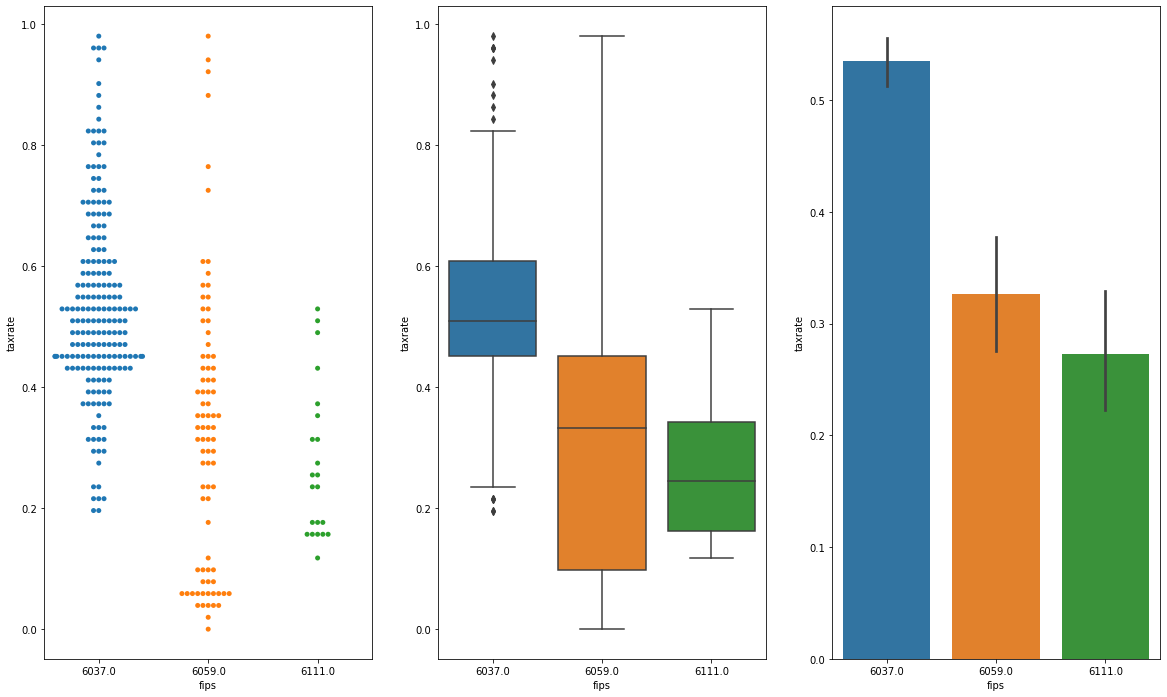

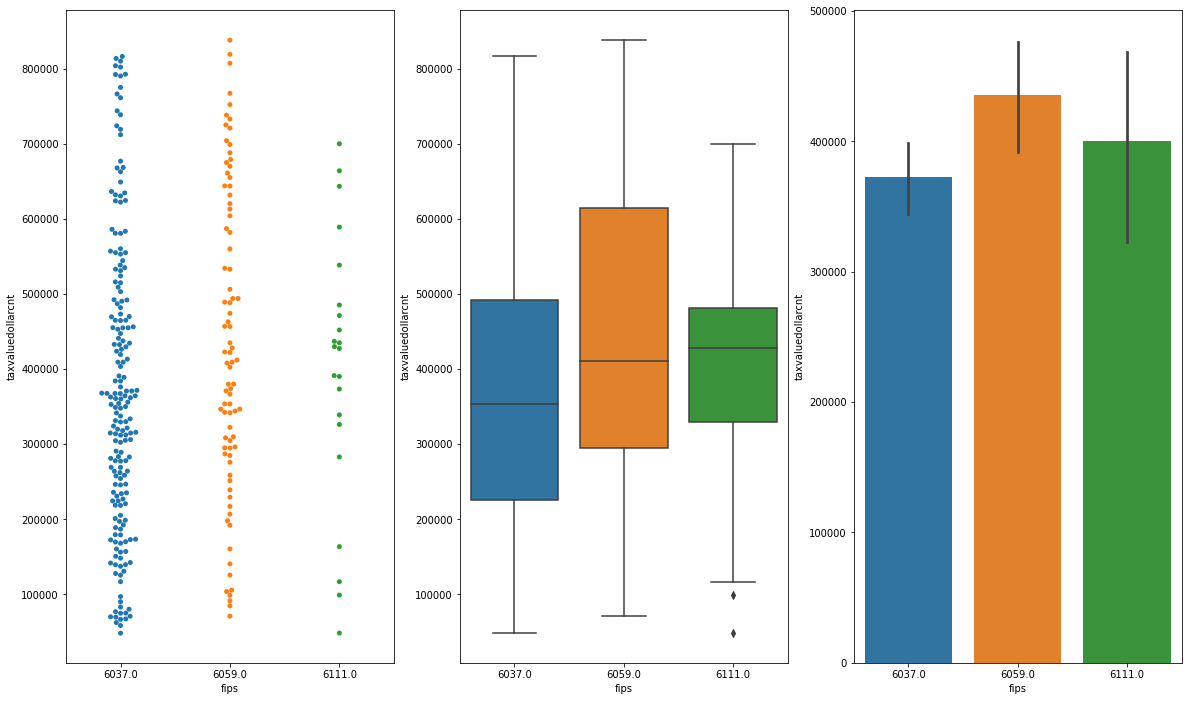

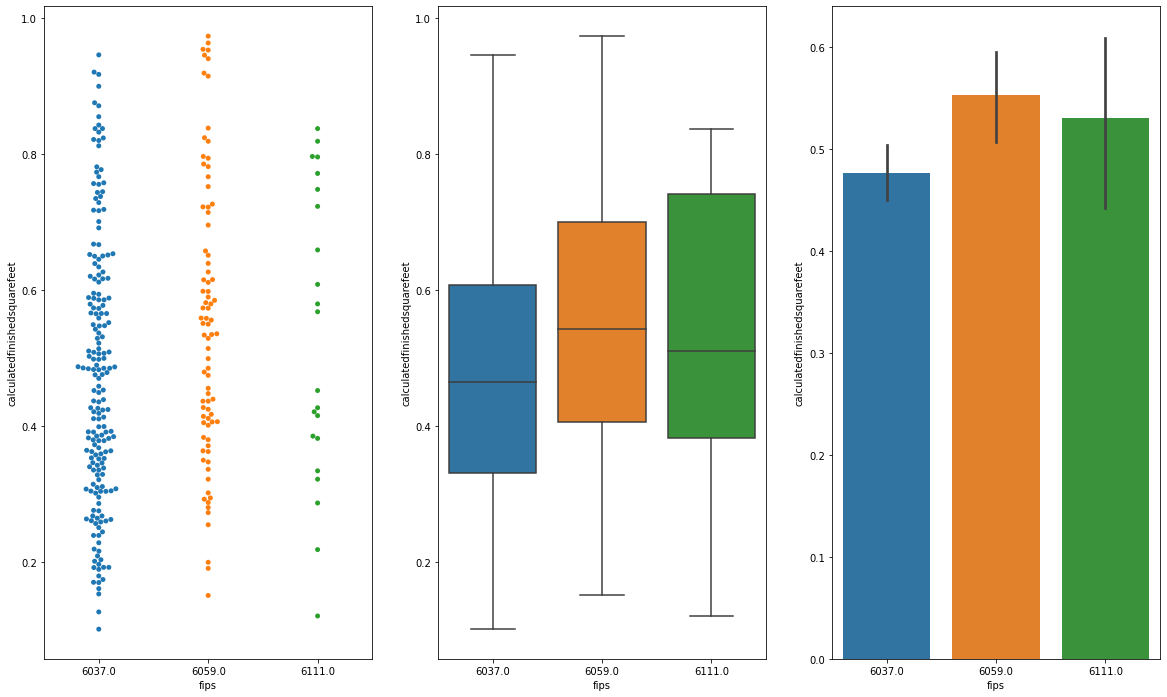

In [18]:
cat_vars = ['bedroomcnt', 'bathroomcnt','fips']
cont_vars = ['yearbuilt','taxrate','taxvaluedollarcnt','calculatedfinishedsquarefeet']
Explore.plot_cat_and_cont(cat_vars,cont_vars,train_scaled.sample(300))

<AxesSubplot:title={'center':'Feautures  Correlating with taxvaluedollarcnt'}>

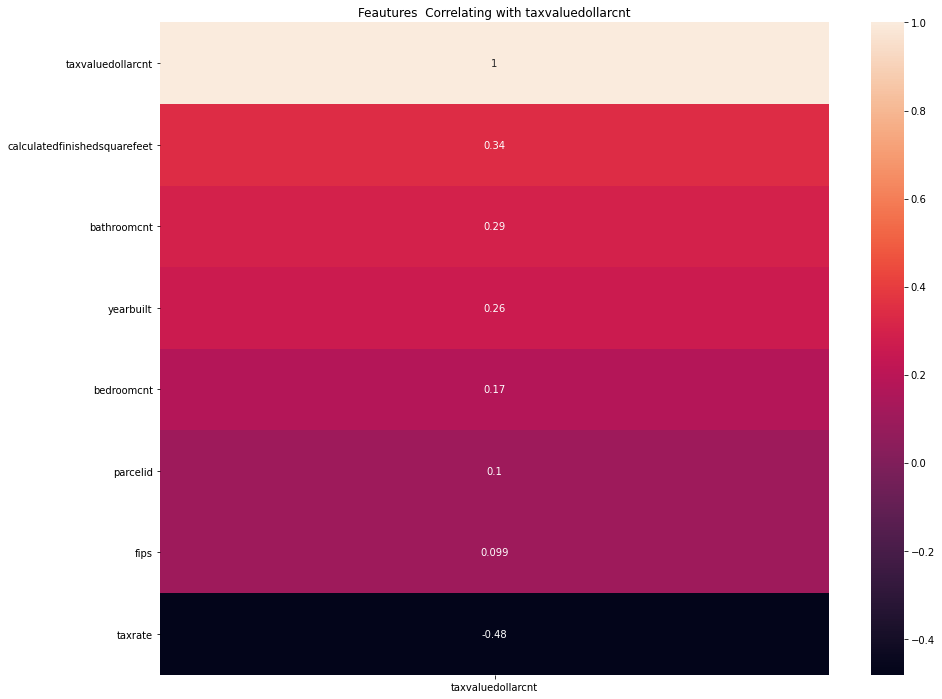

In [19]:
Explore.get_heatmap(train_scaled, 'taxvaluedollarcnt')

### Takeaways

## Modeling